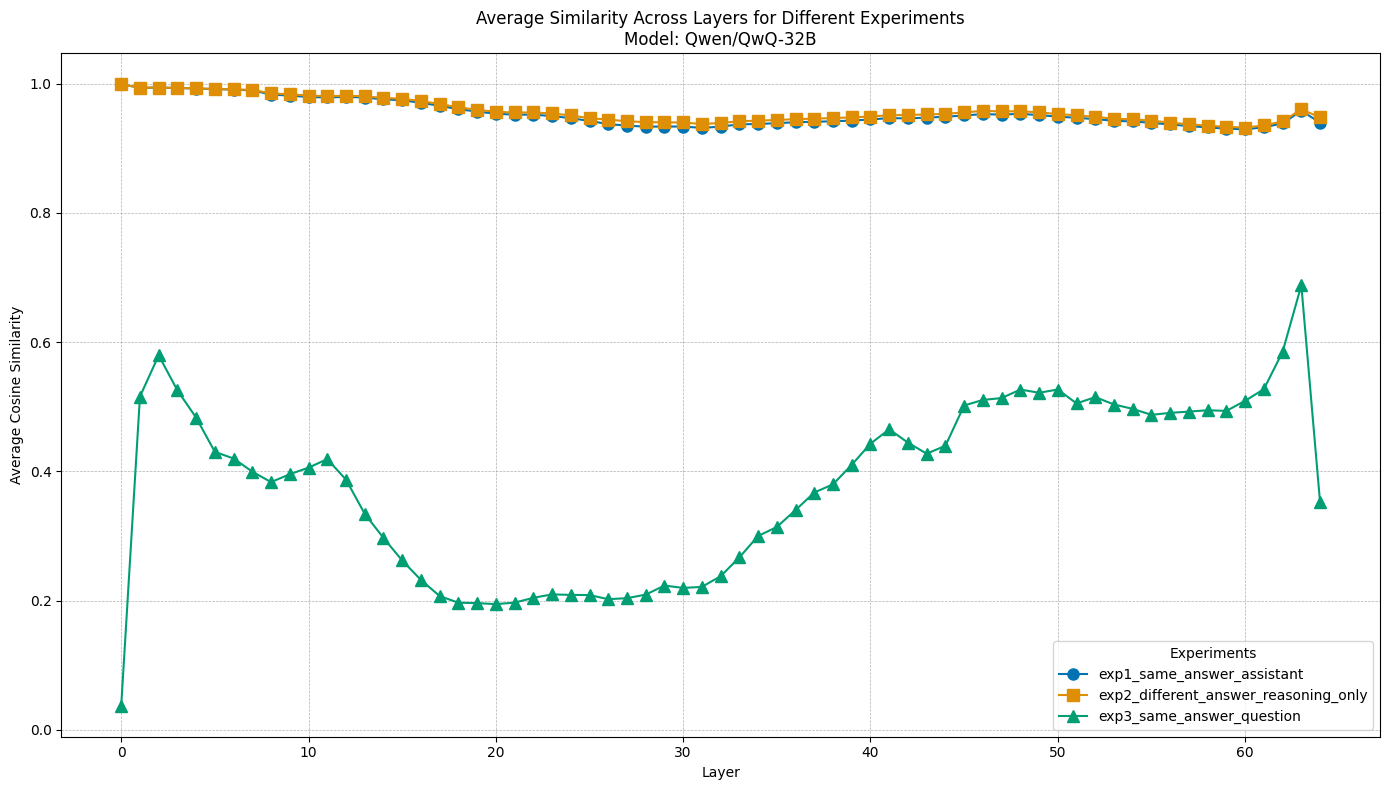

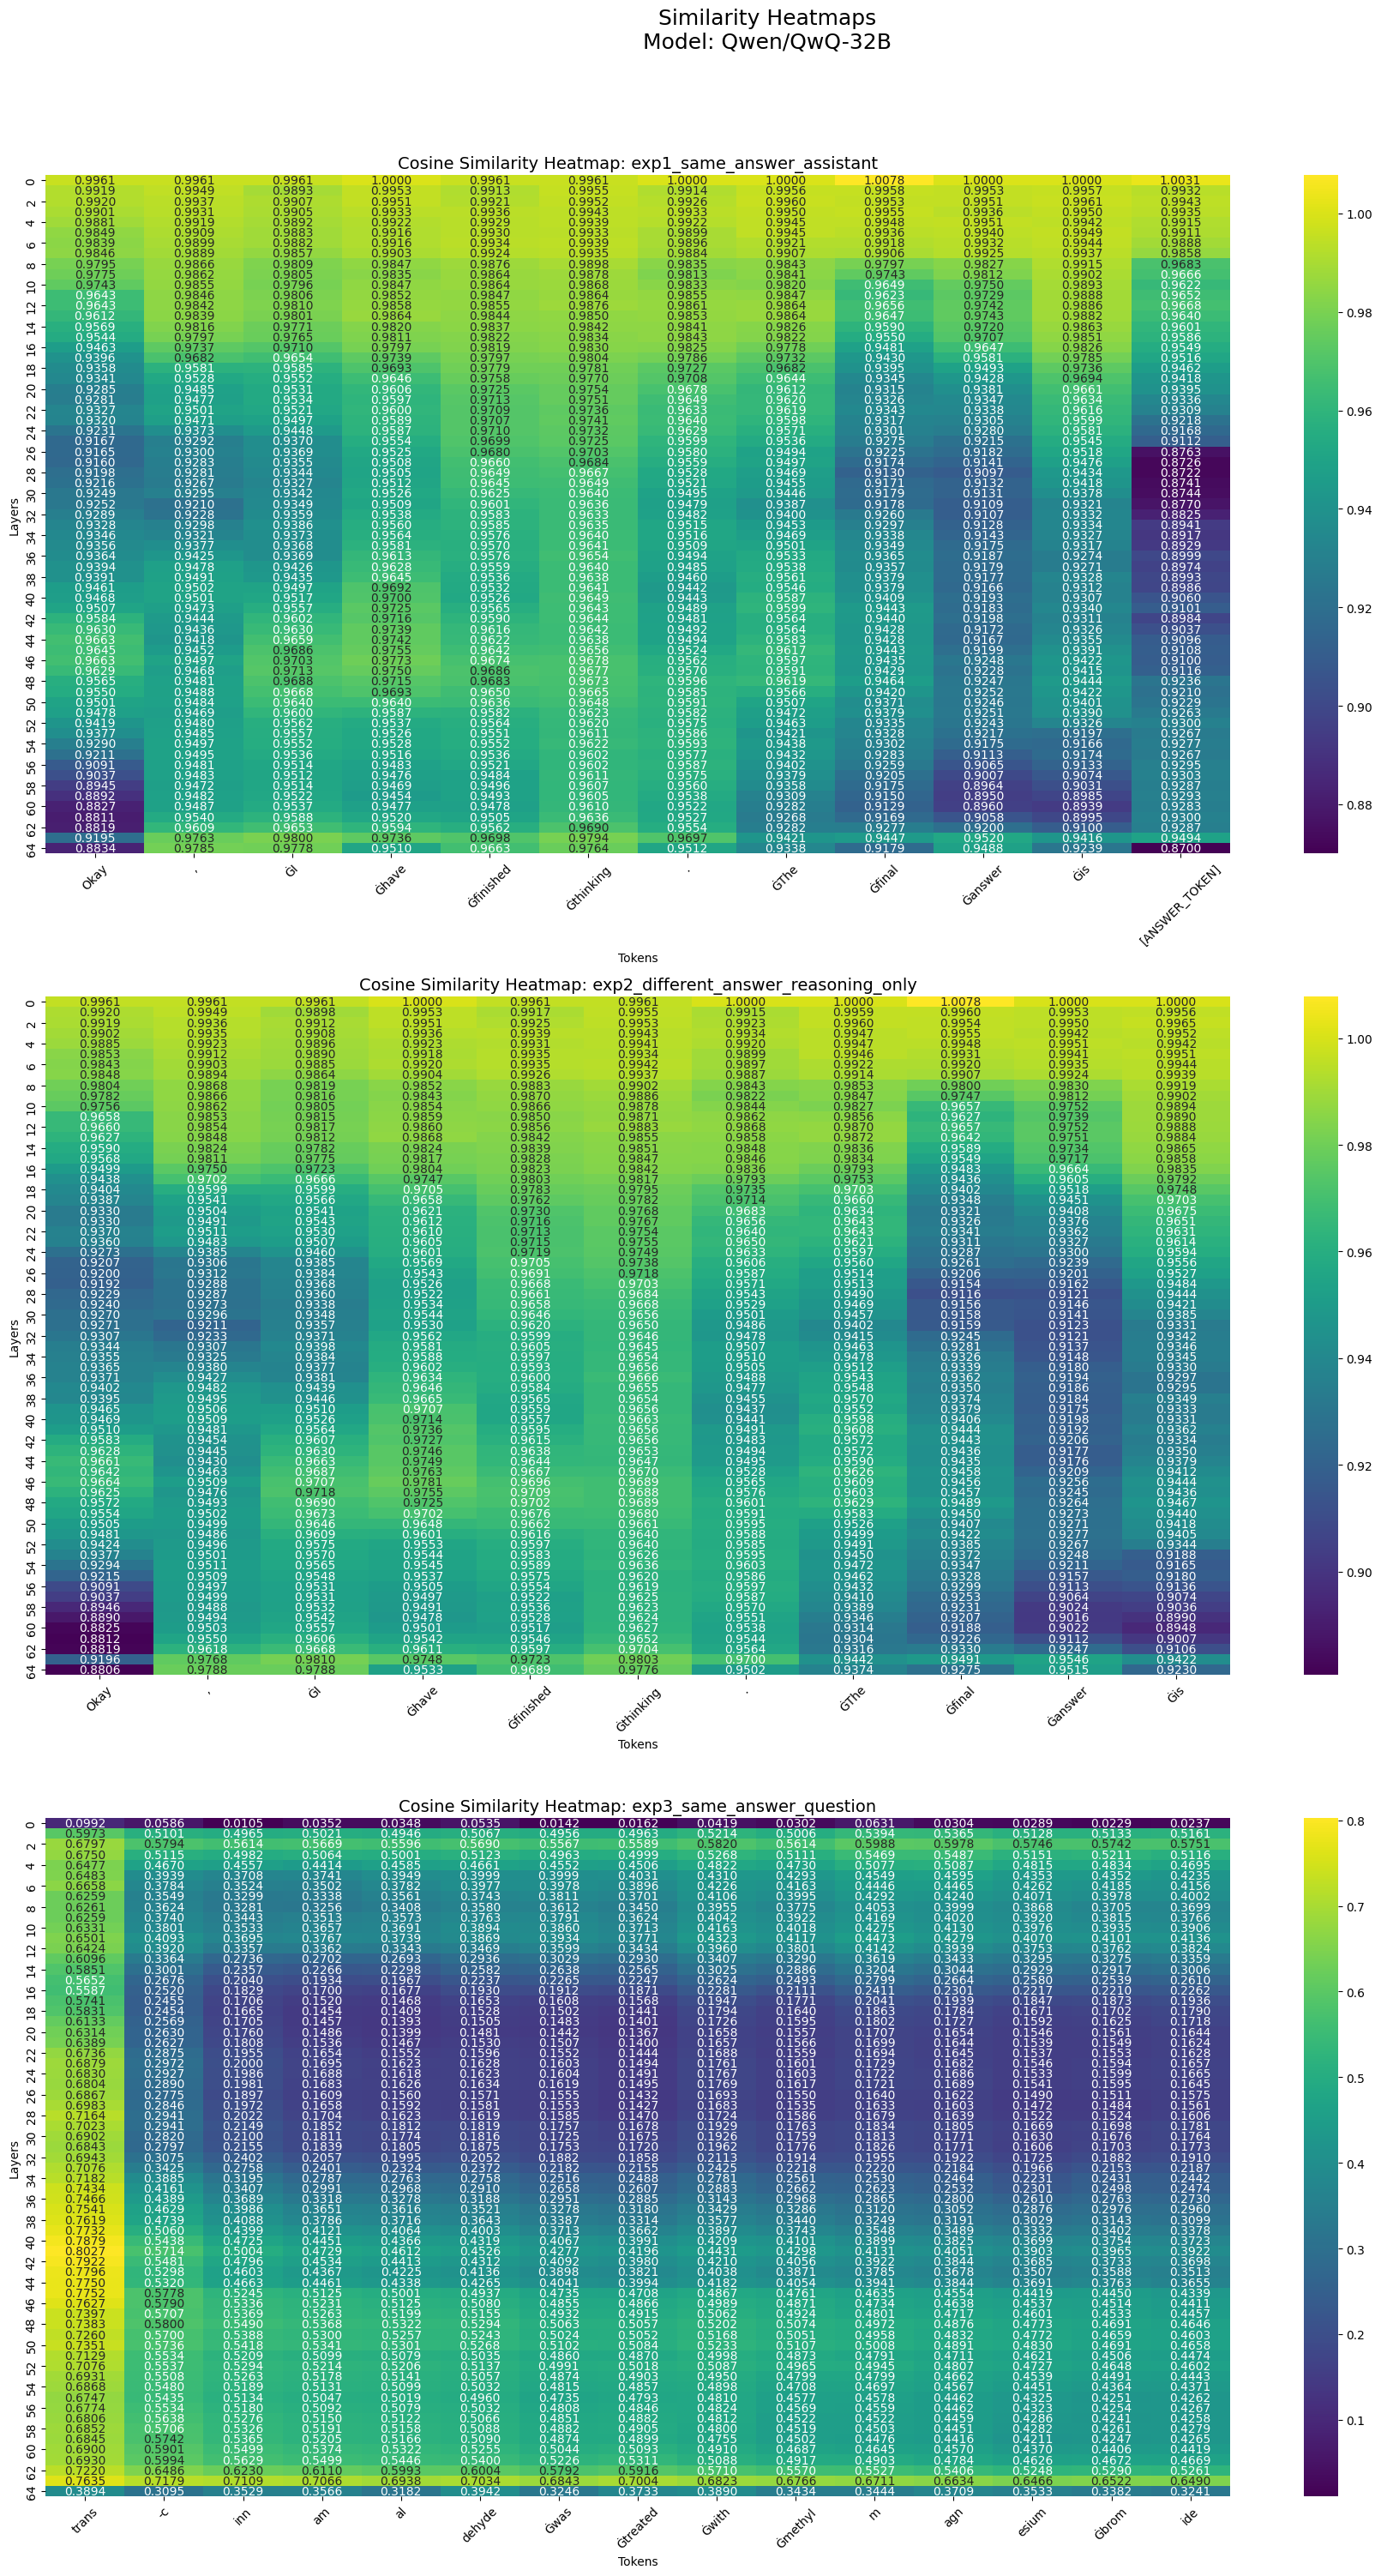

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Specify the path to your results file
results_file_path = '/mnt/nfs_share/tikhonov/reasoning-probing/results/QwQ-32B_20250902_144752/results.json'

# Load the data from the file
try:
    with open(results_file_path, 'r') as f:
        all_experiment_results = json.load(f)
except FileNotFoundError:
    print(f"File not found at path: {results_file_path}")
    # In case of an error, create an empty list so the rest of the code doesn't break
    all_experiment_results = []

if all_experiment_results:
    # --- Combined Line Plot: Average Similarity per Layer (Colorblind-Friendly) ---
    plt.figure(figsize=(14, 8))
    
    # Define a colorblind-friendly color palette and a list of distinct markers
    num_experiments = len(all_experiment_results)
    colors = sns.color_palette("colorblind", n_colors=num_experiments)
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X'] # More can be added if needed

    for i, results in enumerate(all_experiment_results):
        experiment_name = results.get('experiment_name', 'N/A')
        avg_sim_per_layer = results.get('avg_sim_per_layer', [])
        if avg_sim_per_layer:
            plt.plot(
                range(len(avg_sim_per_layer)), 
                avg_sim_per_layer, 
                marker=markers[i % len(markers)],  # Cycle through markers
                linestyle='-', 
                label=experiment_name,
                color=colors[i],                   # Use color from the colorblind-friendly palette
                markersize=8                       # Slightly larger markers for better visibility
            )

    plt.xlabel("Layer")
    plt.ylabel("Average Cosine Similarity")
    plt.title(f"Average Similarity Across Layers for Different Experiments\nModel: {all_experiment_results[0].get('model_name', 'N/A')}")
    plt.legend(title="Experiments")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- Heatmaps: Similarity per Layer and Token for Each Experiment ---
    # The 'viridis' colormap used here is already colorblind-friendly
    fig, axes = plt.subplots(num_experiments, 1, figsize=(18, 10 * num_experiments), squeeze=False)
    axes = axes.flatten()

    for i, results in enumerate(all_experiment_results):
        ax = axes[i]
        experiment_name = results.get('experiment_name', 'N/A')
        avg_sim_per_layer_token = np.array(results.get('avg_sim_per_layer_token', []))
        target_tokens = results.get('target_tokens', [])
        
        if avg_sim_per_layer_token.any():
            sns.heatmap(
                avg_sim_per_layer_token,
                annot=True,
                fmt=".4f",
                cmap="viridis", # This colormap is good for color vision deficiency
                xticklabels=target_tokens,
                ax=ax,
                annot_kws={"size": 10}
            )
            ax.set_xlabel("Tokens")
            ax.set_ylabel("Layers")
            ax.set_title(f"Cosine Similarity Heatmap: {experiment_name}", fontsize=14)
            ax.tick_params(axis='x', rotation=45)

    for j in range(num_experiments, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Similarity Heatmaps\nModel: {all_experiment_results[0].get('model_name', 'N/A')}", fontsize=18, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("No data to display.")

In [9]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-32B")


reasoning_stub = "Okay, I have finished thinking."
revealing_answer_prompt = "The final answer is"


tokenized = tokenizer.apply_chat_template(
    [

        {"role": "user", "content": "what is 1+1?"},
        {"role": "assistant", "content": ""}
    ],
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True   
).replace(
     '<think>\n\n</think>', f'<think>\n\n{reasoning_stub}\n\n</think>'
)

print(tokenized)

<|im_start|>user
what is 1+1?<|im_end|>
<|im_start|>assistant
<think>

Okay, I have finished thinking.

</think>

<|im_end|>
<|im_start|>assistant



In [ ]:
import datasets
import re

# --- Загружаем датасет ПОЛНОСТЬЮ ---
# streaming=False - это ключ к тому, чтобы знать len() и использовать .filter()

print("Loading dataset (this may take some time as streaming=False)...")
dataset = datasets.load_dataset(
    'PrimeIntellect/NuminaMath-QwQ-CoT-5M', 
    cache_dir='/mnt/nfs_share/tikhonov/hf_cache',
    streaming=False
)
train_dataset = dataset['train']
print(f"Dataset loaded. Total examples in 'train': {len(train_dataset):,}")

# --- Наша умная функция фильтрации (остается без изменений) ---
def extract_final_number(text: str):
    """
    Гибкая функция для извлечения единственного числового ответа.
    Приоритет 1: Ищет \boxed{...}.
    Приоритет 2: Проверяет, не является ли вся строка числом.
    """
    if not isinstance(text, str):
        return None
    try:
        matches = re.findall(r'\\boxed\{(.*?)\}', text)
        if len(matches) == 1:
            content = matches[0].strip().replace(',', '')
            return float(content)
    except (ValueError, TypeError):
        pass
    try:
        cleaned_text = text.strip().replace(',', '')
        return float(cleaned_text)
    except (ValueError, TypeError):
        return None

# --- ФИЛЬТРАЦИЯ: ПРАВИЛЬНЫЙ СПОСОБ ---
print("\nFiltering the entire dataset... (progress bar is automatic)")

# Функция для фильтрации должна возвращать True для тех примеров, которые мы хотим оставить
def is_numerical(example):
    return extract_final_number(example['ground_truth']) is not None

# num_proc можно увеличить, если у тебя много ядер CPU, это ускорит процесс
filtered_dataset = train_dataset.filter(is_numerical, num_proc=100) 

# --- Результаты ---
print("\nFiltering complete!")
print(f"Total examples found with a numerical answer: {len(filtered_dataset):,}")
print("=" * 100)

# --- Выводим первые 10 отфильтрованных примеров ---
print("Displaying the first 10 found examples:\n")

# .select() - эффективный способ взять срез
for i, d in enumerate(filtered_dataset.select(range(10))):
    print(f"----------- Example {i+1} -----------")
    print("Prompt:")
    print(d['prompt'])
    print('-' * 50)
    print("Ground Truth:")
    print(d['ground_truth'])
    # Мы можем извлечь число еще раз для наглядности
    extracted_num = extract_final_number(d['ground_truth'])
    print(f"----> Extracted Number for Regression: {extracted_num}")
    print("=" * 100)

Loading dataset (this may take some time as streaming=False)...


Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/87 [00:00<?, ?it/s]

Dataset loaded. Total examples in 'train': 5,138,102

Filtering the entire dataset... (progress bar is automatic)


Filter (num_proc=4):   0%|          | 0/5138102 [00:00<?, ? examples/s]


Filtering complete!
Total examples found with a numerical answer: 1,900,801
Displaying the first 10 found examples:

----------- Example 1 -----------
Prompt:
Given the function $f(x) = \begin{cases} \log_{2}x, & x > 0 \\ 2^{-x}, & x \leqslant 0 \end{cases}$, find the value of $f(2) f(-\log_{2}3)$.
--------------------------------------------------
Ground Truth:
4
----> Extracted Number for Regression: 4.0
----------- Example 2 -----------
Prompt:
I have to run a 20-mile mountain route with the following conditions:

- 4 miles uphill at a pace of 9 minutes per mile
- 3 miles downhill at a pace of 6 minutes per mile
- 7 miles on flat terrain at a pace of 7.5 minutes per mile
- 2 miles uphill at a pace of 10 minutes per mile
- 4 miles downhill at a pace of 6.5 minutes per mile

I need to complete the route in less than 3 hours. Can I meet this time constraint? If so, what will be my average speed in kilometers per hour for the entire route?
----------------------------------------------

In [4]:
train_dataset.filter(is_numerical, num_proc=100) 

Filter (num_proc=100):   0%|          | 0/5138102 [00:00<?, ? examples/s]

Dataset({
    features: ['problem_id', 'prompt', 'response', 'ground_truth', 'correct'],
    num_rows: 1900801
})

In [2]:

count = 0
for example in tqdm(dataset_train_iterable, total=None):
    extracted_number = extract_final_number(example['ground_truth'])
    
    if extracted_number is not None:
        example['extracted_number'] = extracted_number
        filtered_examples.append(example)
        count += 1

# --- Выводим первые 10 отфильтрованных примеров ---

print(f"\nFound {len(filtered_examples)} suitable examples.")
print("=" * 100)
print("Displaying the first 10 found examples:\n")

for i, d in enumerate(filtered_examples):
    print(f"----------- Example {i+1} -----------")
    print("Prompt:")
    print(d['prompt'])
    print('-' * 50)
    print("Ground Truth:")
    print(d['ground_truth'])
    print(f"----> Extracted Number for Regression: {d['extracted_number']}")
    print("=" * 100)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [1]:
import datasets

dataset = datasets.load_dataset('PrimeIntellect/NuminaMath-QwQ-CoT-5M', cache_dir='/mnt/nfs_share/tikhonov/hf_cache')

print(dataset)

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

data/train-00000-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00001-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00002-of-00088.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00003-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00004-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00005-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00006-of-00088.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00007-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00008-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00009-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00010-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00011-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00012-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00013-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00014-of-00088.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

data/train-00015-of-00088.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00016-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00017-of-00088.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00018-of-00088.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

data/train-00019-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00020-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00021-of-00088.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00022-of-00088.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00023-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00024-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00025-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00026-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00027-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00028-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00029-of-00088.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

data/train-00030-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00031-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00032-of-00088.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00033-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00034-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00035-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00036-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00037-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00038-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00039-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00040-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00041-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00042-of-00088.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00043-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00044-of-00088.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00045-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00046-of-00088.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00047-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00048-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00049-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00050-of-00088.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00051-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00052-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00053-of-00088.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00054-of-00088.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00055-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00056-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00057-of-00088.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00058-of-00088.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

data/train-00059-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00060-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00061-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00062-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00063-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00064-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00065-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00066-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00067-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00068-of-00088.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00069-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00070-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

data/train-00071-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00072-of-00088.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00073-of-00088.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

data/train-00074-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00075-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00076-of-00088.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

data/train-00077-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00078-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00079-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00080-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00081-of-00088.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

data/train-00082-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00083-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00084-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00085-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

data/train-00086-of-00088.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00087-of-00088.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5138102 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/87 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['problem_id', 'prompt', 'response', 'ground_truth', 'correct'],
        num_rows: 5138102
    })
})


In [21]:
for d in [dataset['train'][i] for i in range(1000) if not dataset['train'][i]['correct']][:10]:
    print(d['prompt'])
    print('-' * 50)
    print(d['response'])
    print('-' * 50)
    
    print(d['ground_truth'])
    print('=' * 100)


Given the function $f(x) = \begin{cases} \log_{2}x, & x > 0 \\ 2^{-x}, & x \leqslant 0 \end{cases}$, find the value of $f(2) f(-\log_{2}3)$.
--------------------------------------------------
I'm looking at this problem here. I have a function defined in two parts:

$$

f(x) =

\begin{cases}

\log_{2}x, & x > 0 \\

2^{-x}, & x \leqslant 0

\end{cases}

$$

And I need to find the value of \(f(2) f(-\log_{2}3)\). Okay, so first things first, I need to evaluate \(f(2)\) and \(f(-\log_{2}3)\) separately and then multiply them together.

Let's start with \(f(2)\). Since 2 is greater than 0, I'll use the first part of the piecewise function, which is \(\log_{2}x\). So, \(f(2) = \log_{2}2\). I know that \(\log_{2}2 = 1\), because \(2^1 = 2\). So, \(f(2) = 1\).

Next, I need to find \(f(-\log_{2}3)\). First, I need to determine whether \(-\log_{2}3\) is greater than 0 or less than or equal to 0. Since \(\log_{2}3\) is positive (because 3 is greater than 1 and the base 2 is greater than 1), \(-

In [ ]:
for d in [dataset['train'][i] for i in range(1000) if not dataset['train'][i]['correct']][:10]:

In [18]:
dataset['train'][:2]

{'problem_id': [650000, 650001],
 'prompt': ['Given the function $f(x) = \\begin{cases} \\log_{2}x, & x > 0 \\\\ 2^{-x}, & x \\leqslant 0 \\end{cases}$, find the value of $f(2) f(-\\log_{2}3)$.',
  'if 80 percent of the test takers taking an old paper and pencil gmat exam answered the first question on a given math section correctly , and 75 percent of the test takers answered the second question correctly , and 5 percent of the test takers answered neither question correctly , what percent answered both correctly ?'],
 'response': ["I'm looking at this problem here. I have a function defined in two parts:\n\n$$\n\nf(x) =\n\n\\begin{cases}\n\n\\log_{2}x, & x > 0 \\\\\n\n2^{-x}, & x \\leqslant 0\n\n\\end{cases}\n\n$$\n\nAnd I need to find the value of \\(f(2) f(-\\log_{2}3)\\). Okay, so first things first, I need to evaluate \\(f(2)\\) and \\(f(-\\log_{2}3)\\) separately and then multiply them together.\n\nLet's start with \\(f(2)\\). Since 2 is greater than 0, I'll use the first part o

In [8]:
print(dataset['train'][0]['prompt'])

Given the function $f(x) = \begin{cases} \log_{2}x, & x > 0 \\ 2^{-x}, & x \leqslant 0 \end{cases}$, find the value of $f(2) f(-\log_{2}3)$.


In [11]:
dataset['train'][10]

{'problem_id': 650010,
 'prompt': 'If an investor puts $600 in a savings account that earns 10 percent annual interest compounded semiannually, how much money will be in the account after one year?',
 'response': 'So I\'ve got this problem here: an investor puts $600 in a savings account that earns 10 percent annual interest compounded semiannually. I need to figure out how much money will be in the account after one year. Okay, let\'s break this down.\n\nFirst, I need to understand what "compounded semiannually" means. Semiannually means twice a year, so the interest is being added to the account twice a year. That makes sense. So, the annual interest rate is 10%, but since it\'s compounded semiannually, I need to adjust that rate for each compounding period.\n\nI think the formula for compound interest is:\n\n\\[A = P \\left(1 + \\frac{r}{n}\\right)^{nt}\\]\n\nWhere:\n\n- \\(A\\) is the amount of money accumulated after n years, including interest.\n\n- \\(P\\) is the principal amoun

In [5]:
print(dataset['train'][0]['response'])

I'm looking at this problem here. I have a function defined in two parts:

$$

f(x) =

\begin{cases}

\log_{2}x, & x > 0 \\

2^{-x}, & x \leqslant 0

\end{cases}

$$

And I need to find the value of \(f(2) f(-\log_{2}3)\). Okay, so first things first, I need to evaluate \(f(2)\) and \(f(-\log_{2}3)\) separately and then multiply them together.

Let's start with \(f(2)\). Since 2 is greater than 0, I'll use the first part of the piecewise function, which is \(\log_{2}x\). So, \(f(2) = \log_{2}2\). I know that \(\log_{2}2 = 1\), because \(2^1 = 2\). So, \(f(2) = 1\).

Next, I need to find \(f(-\log_{2}3)\). First, I need to determine whether \(-\log_{2}3\) is greater than 0 or less than or equal to 0. Since \(\log_{2}3\) is positive (because 3 is greater than 1 and the base 2 is greater than 1), \(-\log_{2}3\) will be negative. Therefore, I should use the second part of the piecewise function, which is \(2^{-x}\). So, \(f(-\log_{2}3) = 2^{-(-\log_{2}3)} = 2^{\log_{2}3}\).

Now, \(2^{\log

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
import torch
from utils import WordHighlightingStreamerFactory



device = 'cuda'

import logging
import sys

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    stream=sys.stdout,
)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B")
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-8B", torch_dtype=torch.bfloat16).to(device)
# streamer_factory = WordHighlightingStreamerFactory(tokenizer, 'wait', skip_prompt=False)


/mnt/nfs_share/tikhonov/reasoning-probing/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
input_string = 'test\n\nkdjf'
output = tokenizer(input_string, return_offsets_mapping=True)

list(zip(tokenizer.convert_ids_to_tokens(output['input_ids']), output['offset_mapping'], [input_string[i:j] for i, j in output['offset_mapping']]))


[('test', (0, 4), 'test'),
 ('ĊĊ', (4, 6), '\n\n'),
 ('kd', (6, 8), 'kd'),
 ('jf', (8, 10), 'jf')]

In [11]:
from gpqa_dataset import GPQADataset

dataset = GPQADataset(config_name="gpqa_diamond", split="train")



print(len(dataset))
print(dataset[0])

Using the latest cached version of the dataset since Idavidrein/gpqa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'gpqa_diamond' at /home/tikhonov/.cache/huggingface/datasets/Idavidrein___gpqa/gpqa_diamond/0.0.0/90b8e5be2b1d3d2dbfe016cdab47981150600c4a (last modified on Tue Jul 29 18:26:56 2025).


198
{'prompt': 'Two quantum states with energies E1 and E2 have a lifetime of 10^-9 sec and 10^-8 sec, respectively. We want to clearly distinguish these two energy levels. Which one of the following options could be their energy difference so that they can be clearly resolved?\n\n\nA) 10^-9 eV\nB) 10^-8 eV\nC) 10^-4 eV\nD) 10^-11 eV', 'question': 'Two quantum states with energies E1 and E2 have a lifetime of 10^-9 sec and 10^-8 sec, respectively. We want to clearly distinguish these two energy levels. Which one of the following options could be their energy difference so that they can be clearly resolved?\n', 'choices': ['10^-9 eV', '10^-8 eV', '10^-4 eV', '10^-11 eV'], 'answer_letter': 'C', 'answer_index': 2, 'answer_text': '10^-4 eV'}


In [45]:
messages = [
    {"role": "system", "content": "Respond only with the letter of the correct option. Don't write any explanations"},
    {"role": "user", "content": dataset[0]['prompt']},
    {"role": "assistant", "content": "<think>\nOkay,"},
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, continue_final_message=True, enable_thinking=False, add_generation_prompt=False, )
prompt = prompt.replace(
    '<think>\n\n</think>\n\n<think>', '<think>'
)

inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(inputs, max_new_tokens=12800, temperature=0.6, streamer=streamer_factory())
print(tokenizer.decode(output[0], skip_special_tokens=False))

<|im_start|>system
Respond only with the letter of the correct option. Don't write any explanations<|im_end|>
<|im_start|>user
Two quantum states with energies E1 and E2 have a lifetime of 10^-9 sec and 10^-8 sec, respectively. We want to clearly distinguish these two energy levels. Which one of the following options could be their energy difference so that they can be clearly resolved?


A) 10^-9 eV
B) 10^-8 eV
C) 10^-4 eV
D) 10^-11 eV<|im_end|>
<|im_start|>assistant
<think>
Okay, so I need to figure out the energy difference between two quantum states that have different lifetimes, 10^-9 seconds and 10^-8 seconds. The question is asking which energy difference allows us to clearly distinguish these two levels. The options are A) 10^-9 eV, B) 10^-8 eV, C) 10^-4 eV, D) 10^-11 eV.

First, I remember that the energy-time uncertainty principle is involved here. The uncertainty principle relates the uncertainty in energy (ΔE) to the uncertainty in time (Δt), right? The formula is ΔE * Δt ≥

In [35]:
dataset[0]['answer_letter']

'C'

In [47]:
print(tokenizer.convert_ids_to_tokens(output[0][-10:]))

['Ġthe', 'Ġcorrect', 'Ġoption', 'Ġis', 'ĠC', '.Ċ', '</think>', 'ĊĊ', 'C', '<|im_end|>']


In [52]:
tokenizer.tokenize('C')

['C']

In [ ]:
from transformers import AutoModelForCausalLM
import torch

device = 'cuda'

model = AutoModelForCausalLM.from_pretrained(
        'Qwen/Qwen3-32B',
        torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32
    ).to(device)

In [2]:
import requests
import json

url = "https://openrouter.ai/api/v1/chat/completions"
headers = {
    "Authorization": f"Bearer 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",
    "Content-Type": "application/json"
}
payload = {
    "model": "Qwen/Qwen3-32B",
    "messages": [
        {"role": "system", "content": "Respond only with the letter of the correct option. Don't write any explanations"},
        {"role": "user", "content": dataset[0]['prompt']},
    ],
    "include_reasoning": True
}

response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response.json()['choices'][0]['message']['reasoning'])



Okay, so I need to figure out the energy difference between two quantum states that have different lifetimes. The question is asking which of the given options would allow the two energy levels to be clearly resolved. The lifetimes are 10^-9 seconds and 10^-8 seconds. Let me recall what I know about quantum states and their energy levels.

Hmm, there's something called the Heisenberg Uncertainty Principle that relates energy and time, right? I think the formula is ΔE * Δt ≥ ħ/2, where ΔE is the uncertainty in energy and Δt is the uncertainty in lifetime. Wait, so each state has an energy uncertainty inversely proportional to its lifetime. If the lifetimes are different, their energy uncertainties might overlap. To distinguish the two levels, the actual energy difference between them should be larger than the sum of their uncertainties? Or maybe the difference between their uncertainties?

Let me think. If two states have energy uncertainties ΔE1 and ΔE2, the energy levels they represe

In [4]:
response.json()

{'id': 'gen-1753814353-36YFRkFHltUY4E2Zuffo',
 'provider': 'Chutes',
 'model': 'qwen/qwen3-32b',
 'object': 'chat.completion',
 'created': 1753814353,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'native_finish_reason': 'stop',
   'index': 0,
   'message': {'role': 'assistant',
    'content': 'C',
    'refusal': None,
    'reasoning': '\nOkay, so I need to figure out the energy difference between two quantum states that have different lifetimes. The question is asking which of the given options would allow the two energy levels to be clearly resolved. The lifetimes are 10^-9 seconds and 10^-8 seconds. Let me recall what I know about quantum states and their energy levels.\n\nHmm, there\'s something called the Heisenberg Uncertainty Principle that relates energy and time, right? I think the formula is ΔE * Δt ≥ ħ/2, where ΔE is the uncertainty in energy and Δt is the uncertainty in lifetime. Wait, so each state has an energy uncertainty inversely proportional to its li

In [2]:
import sqlite3


db_path = "reasoning_traces.sqlite"


conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute(
    """
    SELECT
        full_prompt_text
    FROM
        reasoning_traces_qpqa
    WHERE
        model_path = 'Qwen/Qwen3-32B'
    """
)

res = cursor.fetchall()



len(res)

190

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-32B")

95th percentile: 11939.299999999996
mean: 5375.8263157894735


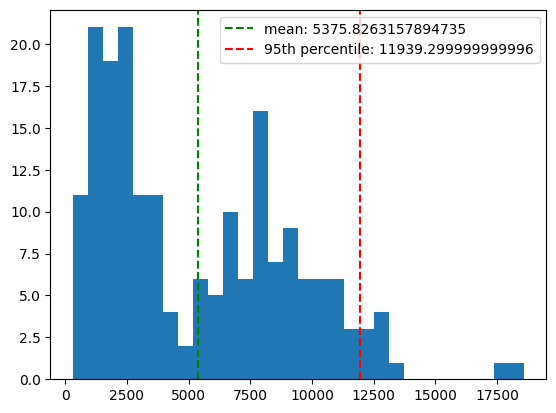

In [6]:
import matplotlib.pyplot as plt
import numpy as np




lengths = [len(tokenizer.encode(r[0])) for r in res]
percentile_95 = np.percentile(lengths, 95)
percentile_90 = np.percentile(lengths, 90)
mean = np.mean(lengths)
median = np.median(lengths)

plt.hist(lengths, bins=30)
plt.axvline(mean, color='green', linestyle='--', label=f'mean: {mean}')
plt.axvline(percentile_95, color='red', linestyle='--', label=f'95th percentile: {percentile_95}')
# plt.axvline(percentile_90, color='blue', linestyle='--', label=f'90th percentile: {percentile_90}')
# plt.axvline(median, color='purple', linestyle='--', label=f'median: {median}')
plt.legend()

# print(f"90th percentile: {percentile_90}")
print(f"95th percentile: {percentile_95}")
print(f"mean: {mean}")
# print(f"median: {median}")
plt.show()

In [8]:
tokenizer.convert_ids_to_tokens(tokenizer.encode(res))

['<|im_start|>',
 'system',
 'Ċ',
 'Respond',
 'Ġonly',
 'Ġwith',
 'Ġthe',
 'Ġletter',
 'Ġof',
 'Ġthe',
 'Ġcorrect',
 'Ġoption',
 '.',
 'ĠDon',
 "'t",
 'Ġwrite',
 'Ġany',
 'Ġexplanations',
 '<|im_end|>',
 'Ċ',
 '<|im_start|>',
 'user',
 'Ċ',
 'The',
 'Ġstate',
 'Ġof',
 'Ġa',
 'Ġsystem',
 'Ġat',
 'Ġtime',
 'Ġt',
 'Ġis',
 'Ġgiven',
 'Ġby',
 'Ġthe',
 'Ġcolumn',
 'Ġmatrix',
 'Ġhaving',
 'Ġelements',
 'Ġ(-',
 '1',
 ',',
 'Ġ',
 '2',
 ',',
 'Ġ',
 '1',
 ').',
 'ĠAn',
 'Ġobservable',
 'Ġof',
 'Ġthe',
 'Ġsystem',
 'Ġis',
 'Ġrepresented',
 'Ġby',
 'Ġthe',
 'Ġmatrix',
 'Ġoperator',
 'ĠP',
 'Ġhaving',
 'Ġelements',
 'Ġin',
 'Ġthe',
 'Ġfirst',
 'Ġrow',
 'Ġas',
 'Ġ(',
 '0',
 ',',
 'Ġ',
 '1',
 '/',
 'Ġ\\',
 'sqrt',
 '{',
 '2',
 '},',
 'Ġ',
 '0',
 '),',
 'Ġ',
 'Ġin',
 'Ġthe',
 'Ġsecond',
 'Ġrow',
 'Ġas',
 'Ġ(',
 '1',
 '/',
 'Ġ\\',
 'sqrt',
 '{',
 '2',
 '},',
 'Ġ',
 '0',
 ',',
 'Ġ',
 '1',
 '/',
 'Ġ\\',
 'sqrt',
 '{',
 '2',
 '})',
 'Ġand',
 'Ġin',
 'Ġthe',
 'Ġthird',
 'Ġrow',
 'Ġas',
 'Ġ(',
 '0',
 ',',
 

In [13]:
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(res))[:500])



['<|im_start|>', 'system', 'Ċ', 'Respond', 'Ġonly', 'Ġwith', 'Ġthe', 'Ġletter', 'Ġof', 'Ġthe', 'Ġcorrect', 'Ġoption', '.', 'ĠDon', "'t", 'Ġwrite', 'Ġany', 'Ġexplanations', '<|im_end|>', 'Ċ', '<|im_start|>', 'user', 'Ċ', 'The', 'Ġstate', 'Ġof', 'Ġa', 'Ġsystem', 'Ġat', 'Ġtime', 'Ġt', 'Ġis', 'Ġgiven', 'Ġby', 'Ġthe', 'Ġcolumn', 'Ġmatrix', 'Ġhaving', 'Ġelements', 'Ġ(-', '1', ',', 'Ġ', '2', ',', 'Ġ', '1', ').', 'ĠAn', 'Ġobservable', 'Ġof', 'Ġthe', 'Ġsystem', 'Ġis', 'Ġrepresented', 'Ġby', 'Ġthe', 'Ġmatrix', 'Ġoperator', 'ĠP', 'Ġhaving', 'Ġelements', 'Ġin', 'Ġthe', 'Ġfirst', 'Ġrow', 'Ġas', 'Ġ(', '0', ',', 'Ġ', '1', '/', 'Ġ\\', 'sqrt', '{', '2', '},', 'Ġ', '0', '),', 'Ġ', 'Ġin', 'Ġthe', 'Ġsecond', 'Ġrow', 'Ġas', 'Ġ(', '1', '/', 'Ġ\\', 'sqrt', '{', '2', '},', 'Ġ', '0', ',', 'Ġ', '1', '/', 'Ġ\\', 'sqrt', '{', '2', '})', 'Ġand', 'Ġin', 'Ġthe', 'Ġthird', 'Ġrow', 'Ġas', 'Ġ(', '0', ',', 'Ġ', '1', '/', 'Ġ\\', 'sqrt', '{', '2', '},', 'Ġ', '0', ').', 'ĠCalculate', 'Ġthe', 'Ġprobability', 'Ġthat', 'Ġthe'

In [2]:
import torch
probe_data = torch.load("probe_data/probe_data_32.pt")

In [3]:
probe_data

[{'hiddens': tensor([[ 0.3008, -0.1045,  1.4453,  ...,  0.8125, -1.7109, -1.4219],
          [ 1.1797,  1.3750,  1.8047,  ...,  0.2637, -0.4727, -0.6406],
          [ 3.8438,  3.5156,  1.1562,  ...,  1.1094,  2.1250,  1.3906],
          ...,
          [-2.7188, -1.2031,  3.5312,  ...,  1.7500,  2.3750, -3.7500],
          [-1.3047, -1.9766,  0.1641,  ...,  2.2031,  1.6562, -2.3281],
          [ 0.2773,  1.9062, -2.4375,  ...,  0.9180,  1.5938, -3.8125]],
         dtype=torch.bfloat16),
  'token_ids': tensor([151667,    198,  32313,  ...,     34, 151645,    198]),
  'ground_truth_idx': 2,
  'model_answer_idx': 2,
  'question_id': 0,
  'prompt_len': 1805},
 {'hiddens': tensor([[ 0.9375,  0.1895,  1.2656,  ...,  0.1035, -1.1797, -1.1328],
          [ 1.3125,  0.1113,  1.6641,  ...,  0.1040, -0.4883, -0.0312],
          [ 4.3750,  1.2188,  1.5469,  ...,  1.5859,  2.4844,  0.9688],
          ...,
          [-1.8750, -2.8906,  5.3125,  ...,  1.4141,  1.1172, -3.4375],
          [-0.8516, -2.

In [4]:
from collections import Counter
print(Counter([x['model_answer_idx'] for x in probe_data]))
print(Counter([x['ground_truth_idx'] for x in probe_data]))

Counter({1: 55, 2: 48, 0: 38, 3: 37, -1: 5})
Counter({1: 54, 0: 47, 3: 43, 2: 39})


In [9]:
import pandas as pd

df = pd.read_csv('/home/tikhonov/projects/reasoning-probe-classifier/probe_predictions/val_details_epoch50_lstm.csv')
df.head().to_csv('temp.csv', index=False)

In [12]:
from gpqa_dataset import GPQADataset
from datasets import load_dataset

GPQADataset(config_name='gpqa_main', split="train")

In [5]:
!ls /home/tikhonov/.cache/huggingface/datasets/Idavidrein___gpqa/

gpqa_diamond  gpqa_extended
